# INM430 - Principles of Data Science - Final Project - Rudra Rajeev Grover
### ID: 170058598

## HR Analytics - Employee Promotion Prediction


## Problem Statement & Competition Background

This problem is a practice competition sourced from the data science / analytics competition site, Analytics Vidhya. It centers around the domain of HR analytics. The competition requires participants to analyze employee demographics, past and present performance data, to make a prediction whether they will be promoted or not and thus expedite the promotion cycle.

## Data Description

Train set: 54,809 entries.

Test set: 23,491 entries.

Columns: 14; 1 id, 1 target and 12 explanatory variables (4 Numeric, 8 Categorical).

| **Variable** |	**Definition** |
|------|------|
| employee_id |	Unique ID for employee |
| department |	Department of employee |
| region |	Region of employment (unordered) |
| education |	Education Level |
| gender |	Gender of Employee |
| recruitment_channel |	Channel of recruitment for employee |
| no_of_trainings |	no of other trainings completed in previous year on soft skills, technical skills etc. |
| age |	Age of Employee |
| previous_year_rating |	Employee Rating for the previous year |
| length_of_service |	Length of service in years |
| KPIs_met >80% |	if Percent of KPIs(Key performance Indicators) >80% then 1 else 0 |
| awards_won? |	if awards won during previous year then 1 else 0 |
| avg_training_score |	Average score in current training evaluations |
| is_promoted |	(Target, Binary: 1/0) Recommended for promotion |

## Metric Description

Participants are ranked on the F1 Score (harmonic mean of Precision and Recall; https://en.wikipedia.org/wiki/F1_score) on test set.

# CODE

In [1]:
# import relevant basic libraries: numpy, scipy and pandas (data analysis), matplotlib and seaborn (plotting),
# sklearn (machine learning)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# machine learning - Classifiers, Metrics, Cross Validation, Grid Search
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

from loo_encoder.encoder import LeaveOneOutEncoder

In [2]:
# Function. Source: https://www.kaggle.com/arindambanerjee/grid-search-simplified
# This function is sed to plot the confusion matrix for each model

def plot_conf_matrix (conf_matrix, dtype):
    class_names = [0,1]
    fontsize=14
    df_conf_matrix = pd.DataFrame(
            conf_matrix, index=class_names, columns=class_names, 
        )
    fig = plt.figure()
    heatmap = sns.heatmap(df_conf_matrix, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix for {0}'.format(dtype))

In [3]:
# Load training and test data
df_train = pd.read_csv('C:/Users/Rudra/Desktop/HR_Problem/train.csv')
df_test = pd.read_csv('C:/Users/Rudra/Desktop/HR_Problem/test.csv')


# Clean columns names to ensure that they all are in lower case and treats spaces, >, % etc.
df_train.columns = df_train.columns.str.strip().str.lower().str.replace(' ', '_').\
    str.replace('(', '').str.replace(')', '').str.replace('>', '').str.replace('%', '').str.replace('?', '')
df_test.columns = df_test.columns.str.strip().str.lower().str.replace(' ', '_').\
    str.replace('(', '').str.replace(')', '').str.replace('>', '').str.replace('%', '').str.replace('?', '')

# Section 1 - Exploratory Data Analysis Section

In [4]:
# Converting the data types for the categorical variables from object/int to categorical

df_train['department'] = pd.Categorical(df_train.department)  
df_train['region'] = pd.Categorical(df_train.region)
df_train['education'] = pd.Categorical(df_train.education)
df_train['gender'] = pd.Categorical(df_train.gender)  
df_train['recruitment_channel'] = pd.Categorical(df_train.recruitment_channel) 
df_train['previous_year_rating'] = pd.Categorical(df_train.previous_year_rating)
df_train['kpis_met_80'] = pd.Categorical(df_train.kpis_met_80)
df_train['awards_won'] = pd.Categorical(df_train.awards_won)
df_train['is_promoted'] = pd.Categorical(df_train.is_promoted)

df_test['department'] = pd.Categorical(df_test.department)  
df_test['region'] = pd.Categorical(df_test.region)
df_test['education'] = pd.Categorical(df_test.education)
df_test['gender'] = pd.Categorical(df_test.gender)  
df_test['recruitment_channel'] = pd.Categorical(df_test.recruitment_channel)
df_test['previous_year_rating'] = pd.Categorical(df_test.previous_year_rating)  
df_test['kpis_met_80'] = pd.Categorical(df_test.kpis_met_80)
df_test['awards_won'] = pd.Categorical(df_test.awards_won)
                                                                                                
print (df_train.dtypes)
print (df_test.dtypes)

# Splitting the variables in the data into groups. Exploratory data analysis will be conducted for the
# variables in these groups together, specifically the numerical, categorical and target groups.

ids = [
    'employee_id'
]

numerical = [
  'no_of_trainings', 'age', 'length_of_service', 'avg_training_score'
]
categorical = [
  'department', 'region', 'education', 'gender', 'recruitment_channel', 'previous_year_rating', \
    'kpis_met_80', 'awards_won'
]
target = [
    'is_promoted'
]

# Creating a copy of the data for analysis lest so that in case any mistakes are made we have the original
# data to fall back on. 
df_explore_train = df_train[ids + numerical + categorical + target]
df_explore_test = df_test[ids + numerical + categorical]

# Check the shape of the new data to make sure it looks ok
print(df_explore_train.shape)
print(df_explore_test.shape)

employee_id                int64
department              category
region                  category
education               category
gender                  category
recruitment_channel     category
no_of_trainings            int64
age                        int64
previous_year_rating    category
length_of_service          int64
kpis_met_80             category
awards_won              category
avg_training_score         int64
is_promoted             category
dtype: object
employee_id                int64
department              category
region                  category
education               category
gender                  category
recruitment_channel     category
no_of_trainings            int64
age                        int64
previous_year_rating    category
length_of_service          int64
kpis_met_80             category
awards_won              category
avg_training_score         int64
dtype: object
(54808, 14)
(23490, 13)


In [5]:
#Check to make sure that the datatypes have also changed
print (df_explore_train.dtypes)
print (df_explore_test.dtypes)

employee_id                int64
no_of_trainings            int64
age                        int64
length_of_service          int64
avg_training_score         int64
department              category
region                  category
education               category
gender                  category
recruitment_channel     category
previous_year_rating    category
kpis_met_80             category
awards_won              category
is_promoted             category
dtype: object
employee_id                int64
no_of_trainings            int64
age                        int64
length_of_service          int64
avg_training_score         int64
department              category
region                  category
education               category
gender                  category
recruitment_channel     category
previous_year_rating    category
kpis_met_80             category
awards_won              category
dtype: object


## 1.1 Univariate Analysis

###  1.1.1 Finding number of total values per feature (infer columns with missing values)

In [6]:
# For number of entries per column
df_train.info()
print('-'*40)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             54808 non-null int64
department              54808 non-null category
region                  54808 non-null category
education               52399 non-null category
gender                  54808 non-null category
recruitment_channel     54808 non-null category
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null category
length_of_service       54808 non-null int64
kpis_met_80             54808 non-null category
awards_won              54808 non-null category
avg_training_score      54808 non-null int64
is_promoted             54808 non-null category
dtypes: category(9), int64(5)
memory usage: 2.6 MB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
employee_id             23490 non

Notes:

1. Training: 54,808 rows (one for each employee each).


2. Test: 23,490 rows.


3. Missing values in 'education' and 'previous_year_rating'.

### 1.1.2 Analysis of categorical features

#### 1.1.2.1 Summaries

In [7]:
# describe categorical variables in training data
df_explore_train[categorical + target].describe()

,department,region,education,gender,recruitment_channel,previous_year_rating,kpis_met_80,awards_won,is_promoted
count,54808,54808,52399,54808,54808,50684.0,54808,54808,54808
unique,9,34,3,2,3,5.0,2,2,2
top,Sales & Marketing,region_2,Bachelor's,m,other,3.0,0,0,0
freq,16840,12343,36669,38496,30446,18618.0,35517,53538,50140


In [8]:
# describe categorical variables in test data
df_explore_test[categorical].describe()

,department,region,education,gender,recruitment_channel,previous_year_rating,kpis_met_80,awards_won
count,23490,23490,22456,23490,23490,21678.0,23490,23490
unique,9,34,3,2,3,5.0,2,2
top,Sales & Marketing,region_2,Bachelor's,m,other,3.0,0,0
freq,7315,5299,15578,16596,13078,7921.0,15061,22955


Notes:

1. 'department'and 'region' have a lot of categories (9 and 34 respectively). Will require special handling.


2. Missing values in 'education' (~4.4% in both training and test data) and 'previous_year_rating' (7.52% and 7.71% in training and test respectively i.e. slightly more in the test data).

#### 1.1.2.2 Category Count Tables

Counting the number of values per category to: (a) find categories which are very low in frequency; and (b) compare distributions across training and test data.

In [9]:
# counts & % for employees per department for training data
pd.concat([df_explore_train['is_promoted'].value_counts(dropna = False),\
           df_explore_train['is_promoted'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
0,50140,91.482995
1,4668,8.517005


Notes:

1. Only 8.52% of the employees were promoted ("Unbalanced Class" problem).

2. Less than 1 in 10 employees get promoted which seems a very low number.

In [10]:
# counts & % for employees per department for training data
pd.concat([df_explore_train['department'].value_counts(dropna = False),\
           df_explore_train['department'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
Sales & Marketing,16840,30.725442
Operations,11348,20.705007
Technology,7138,13.023646
Procurement,7138,13.023646
Analytics,5352,9.764998
Finance,2536,4.627062
HR,2418,4.411765
Legal,1039,1.895709
R&D,999,1.822727


In [11]:
# counts & % for employees per department for test data
pd.concat([df_explore_test['department'].value_counts(dropna = False),\
           df_explore_test['department'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
Sales & Marketing,7315,31.140911
Operations,4764,20.280971
Procurement,3020,12.856535
Technology,3011,12.818221
Analytics,2319,9.872286
Finance,1091,4.644530
HR,1085,4.618987
Legal,445,1.894423
R&D,440,1.873138


In [12]:
# counts & % for employees per region for training data
pd.concat([df_explore_train['region'].value_counts(dropna = False),\
           df_explore_train['region'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
region_2,12343,22.520435
region_22,6428,11.728215
region_7,4843,8.836301
region_15,2808,5.123340
region_13,2648,4.831411
region_26,2260,4.123486
region_31,1935,3.530506
region_4,1703,3.107211
region_27,1659,3.026930
region_16,1465,2.672967


In [13]:
# counts & % for employees per region for test data
pd.concat([df_explore_test['region'].value_counts(dropna = False),\
           df_explore_test['region'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
region_2,5299,22.558536
region_22,2739,11.660281
region_7,1982,8.437633
region_13,1167,4.968072
region_15,1130,4.810558
region_26,1011,4.303959
region_31,844,3.593018
region_4,775,3.299276
region_27,710,3.022563
region_28,595,2.532993


In [14]:
# counts & % for employees per education group for training data
pd.concat([df_explore_train['education'].value_counts(dropna = False),\
           df_explore_train['education'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
Bachelor's,36669,66.904467
Master's & above,14925,27.231426
NaN,2409,4.395344
Below Secondary,805,1.468764


In [15]:
# counts & % for employees per education group for test data
pd.concat([df_explore_test['education'].value_counts(dropna = False),\
           df_explore_test['education'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
Bachelor's,15578,66.317582
Master's & above,6504,27.688378
NaN,1034,4.401873
Below Secondary,374,1.592167


In [16]:
# counts & % for employees per gender group for training data
pd.concat([df_explore_train['gender'].value_counts(dropna = False),\
           df_explore_train['gender'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
m,38496,70.237921
f,16312,29.762079


In [17]:
# counts & % for employees per gender group for test data
pd.concat([df_explore_test['gender'].value_counts(dropna = False),\
           df_explore_test['gender'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
m,16596,70.651341
f,6894,29.348659


In [18]:
# counts & % for employees per recruitment channel for training data
pd.concat([df_explore_train['recruitment_channel'].value_counts(dropna = False),\
           df_explore_train['recruitment_channel'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
other,30446,55.550285
sourcing,23220,42.366078
referred,1142,2.083637


In [19]:
# counts & % for employees per recruitment channel for test data
pd.concat([df_explore_test['recruitment_channel'].value_counts(dropna = False),\
           df_explore_test['recruitment_channel'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
other,13078,55.674755
sourcing,9961,42.405279
referred,451,1.919966


In [20]:
# counts & % for employees per each previous year rating category for training data
pd.concat([df_explore_train['previous_year_rating'].value_counts(dropna = False),\
           df_explore_train['previous_year_rating'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
3.0,18618,33.969494
5.0,11741,21.422055
4.0,9877,18.021092
1.0,6223,11.354182
2.0,4225,7.708729
NaN,4124,7.524449


In [21]:
# counts & % for employees per each previous year rating category for test data
pd.concat([df_explore_test['previous_year_rating'].value_counts(dropna = False),\
           df_explore_test['previous_year_rating'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
3.0,7921,33.720732
5.0,5097,21.698595
4.0,4249,18.088548
1.0,2680,11.409110
NaN,1812,7.713921
2.0,1731,7.369093


In [22]:
# counts & % for employees who did and did not have KPIs > 80% for training data
pd.concat([df_explore_train['kpis_met_80'].value_counts(dropna = False),\
           df_explore_train['kpis_met_80'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
0,35517,64.802584
1,19291,35.197416


In [23]:
# counts & % for employees who did and did not have KPIs > 80% for test data
pd.concat([df_explore_test['kpis_met_80'].value_counts(dropna = False),\
           df_explore_test['kpis_met_80'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
0,15061,64.116645
1,8429,35.883355


In [24]:
# counts & % for employees who did and did not win awards for training data
pd.concat([df_explore_train['awards_won'].value_counts(dropna = False),\
           df_explore_train['awards_won'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
0,53538,97.68282
1,1270,2.31718


In [25]:
# counts & % for employees who did and did not win awards for test data
pd.concat([df_explore_test['awards_won'].value_counts(dropna = False),\
           df_explore_test['awards_won'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
0,22955,97.722435
1,535,2.277565


In [26]:
# counts & % for employees who were and were not promoted for training data
pd.concat([df_explore_train['is_promoted'].value_counts(dropna = False),\
           df_explore_train['is_promoted'].value_counts(normalize = True, dropna = False).mul(100)],\
          axis=1, keys=('counts','percentage'))

,counts,percentage
0,50140,91.482995
1,4668,8.517005


#### 1.1.2.3 Category Count Plots

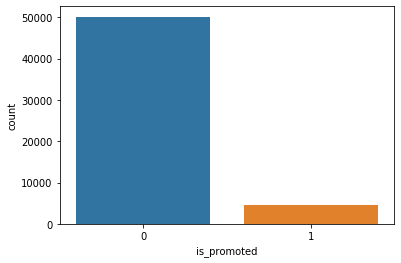

In [27]:
# Plot the count plot for the target variable in the training data
sns.countplot(df_explore_train['is_promoted']);

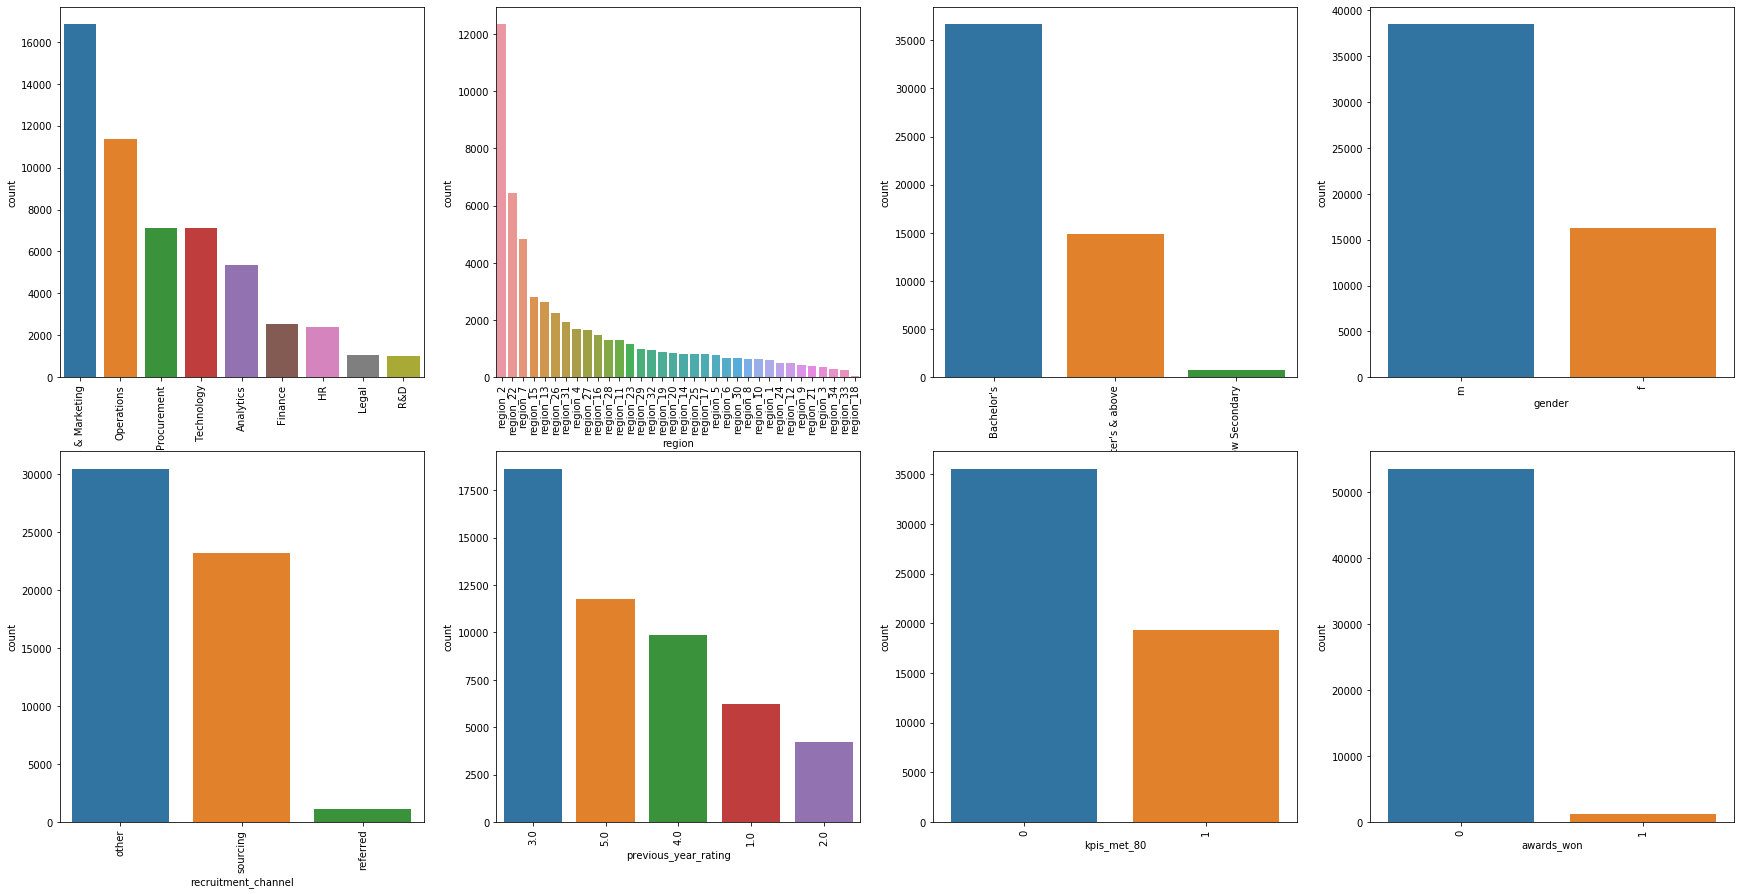

In [28]:
# Plot first for training data
fig, ax = plt.subplots(2, 4, figsize=(30, 15))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df_explore_train[variable], ax=subplot,\
                  order = df_explore_train[variable].value_counts().sort_values(ascending=False).index)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Notes:

4 out of 9 departments contribute >75% of the employees.

Only 5 regions (2, 22, 7, 15 and 13) contribute >50% of the employees in the data. Region 2 alone contributes 23% of the employees.

Most of the employees have just a Bachelor's degree (~67%; can be used for missing value replacement), with a very small percentage having Below Secondary education (~1.5%).


Male:Female ratio is approximately 70:30.


Only 2% of the recruitment happens through referrals, representing an opportunity for the company to incentivize referrals.


Roughly 33% received a rating of 3 in the previous year, representing some sort of an average rating (can be used for missing value treatment).


Only 35% of the employees met more than 80% of the KPIs (the problem statement states that only KPIs over 60% are considered for promotion).


Only about 2% of the employees have won awards.

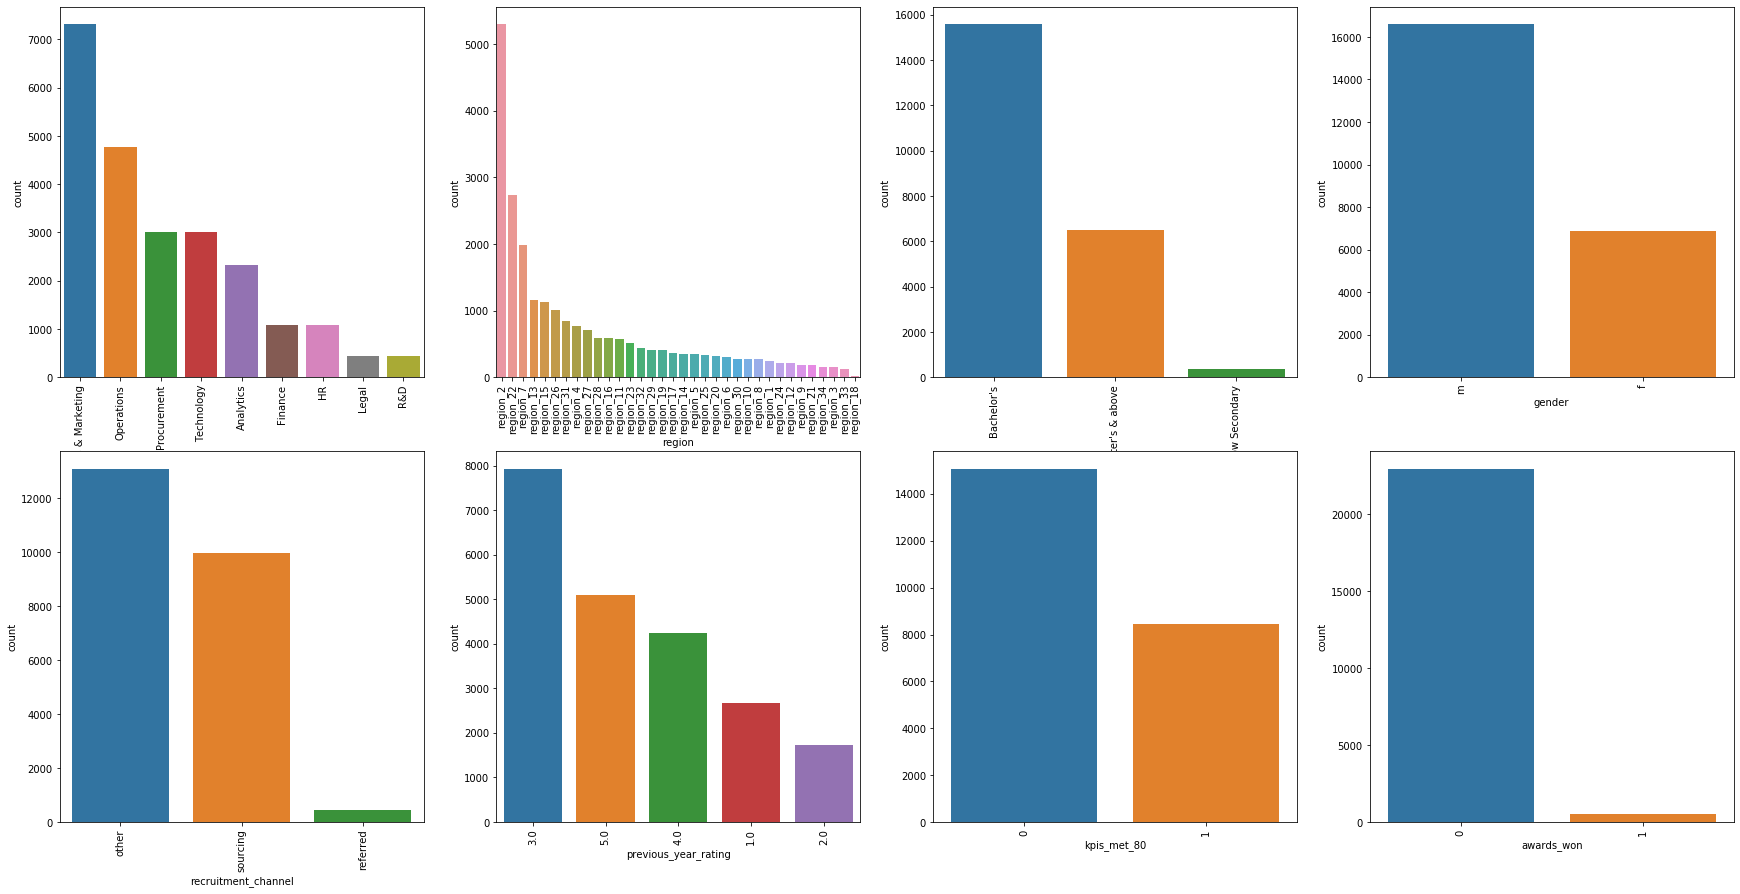

In [29]:
# Plot next for test data
fig, ax = plt.subplots(2, 4, figsize=(30, 15))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df_explore_test[variable], ax=subplot,\
                  order = df_explore_test[variable].value_counts().sort_values(ascending=False).index)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Distributions of the categorical variables are almost identical across test and training. So performance drop from training to testing can be minimized if model is built appropriately on training data.

### 1.1.3 Analysis of numerical features

#### 1.1.3.1 Summary Statistics

In [30]:
# First define the percentiles to display in the summary statistics
perc = [ 0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]

# Display summary statistics for the training data
df_explore_train[numerical].describe(percentiles=perc)

,no_of_trainings,age,length_of_service,avg_training_score
count,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,5.865512,63.386750
std,0.609264,7.660169,4.265094,13.371559
min,1.000000,20.000000,1.000000,39.000000
1%,1.000000,23.000000,1.000000,44.000000
5%,1.000000,25.000000,1.000000,47.000000
10%,1.000000,27.000000,2.000000,48.000000
25%,1.000000,29.000000,3.000000,51.000000
50%,1.000000,33.000000,5.000000,60.000000
75%,1.000000,39.000000,7.000000,76.000000


Most employees (75% or greater) have completed only 1 training. Outlier employees at the upper end between 99%-ile (4) and maximum (10).


Employees range in age between 20 and 60 (which could be the retirement age). No outliers.


Length of service: Median employee has 5 years of service with more than 75% having 3 years of service.


Average training scores: Median employee has a score of 60 with outliers at the upper end (91 at the 99%-ile and 99 at the maximum).


Outliers can be capped at the 99%-ile to shoot for improved model performance.

In [31]:
# Display summary statistics for the test data
df_explore_test[numerical].describe(percentiles=perc)

,no_of_trainings,age,length_of_service,avg_training_score
count,23490.000000,23490.000000,23490.000000,23490.000000
mean,1.254236,34.782929,5.810387,63.263133
std,0.600910,7.679492,4.207917,13.411750
min,1.000000,20.000000,1.000000,39.000000
1%,1.000000,23.000000,1.000000,44.000000
5%,1.000000,25.000000,1.000000,47.000000
10%,1.000000,27.000000,2.000000,48.000000
25%,1.000000,29.000000,3.000000,51.000000
50%,1.000000,33.000000,5.000000,60.000000
75%,1.000000,39.000000,7.000000,76.000000


#### 1.1.3.2 Histogram analysis

In [32]:
# Set the parameters for the histogram plot 
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

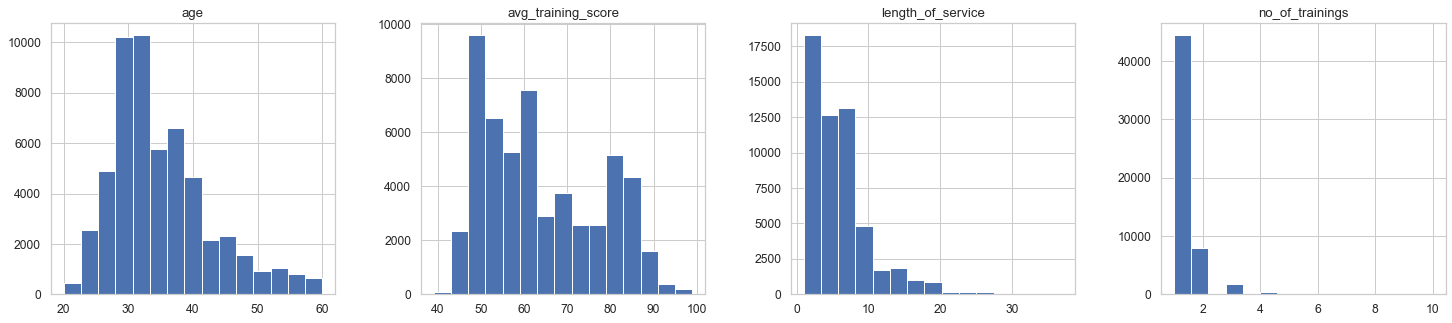

In [33]:
# Plot the histograms for the numerical variables in the training data
df_explore_train[numerical].hist(bins=15, figsize=(25, 5), layout=(1, 4));

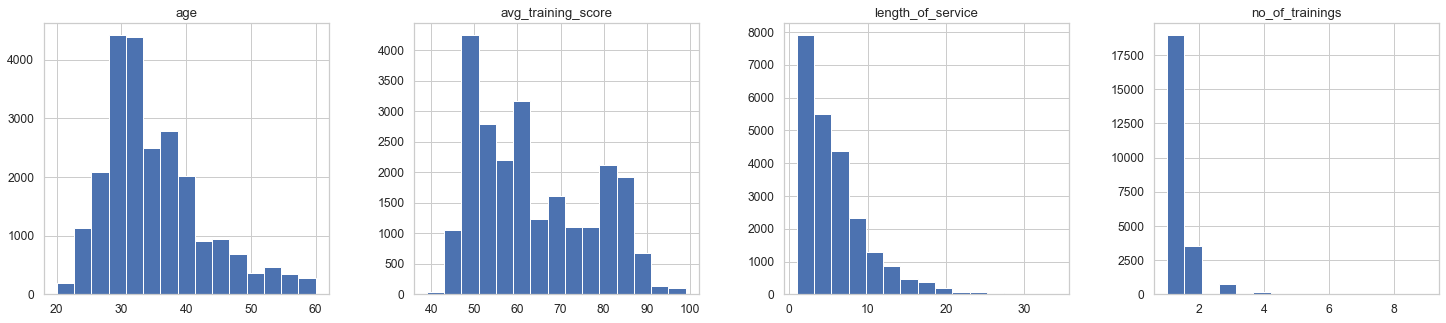

In [34]:
# Plot the histograms for the numerical variables in the test data
df_explore_test[numerical].hist(bins=15, figsize=(25, 5), layout=(1, 4));

Visually, distributions of the numerical variables in the test data is almost identical to that seen in training data. Only for 'length_of_service' under 10 years do the distributions look a little different. All the variables have a skew to the left.

## 1.2 Bivariate Analysis

### 1.2.2 Target variable vs numerical variables

#### 1.2.2.1 Box and Whisker Plots

Box and whisker plots are used to view the relationship between the target variable and the numerical variables. This can be done only for the training data.

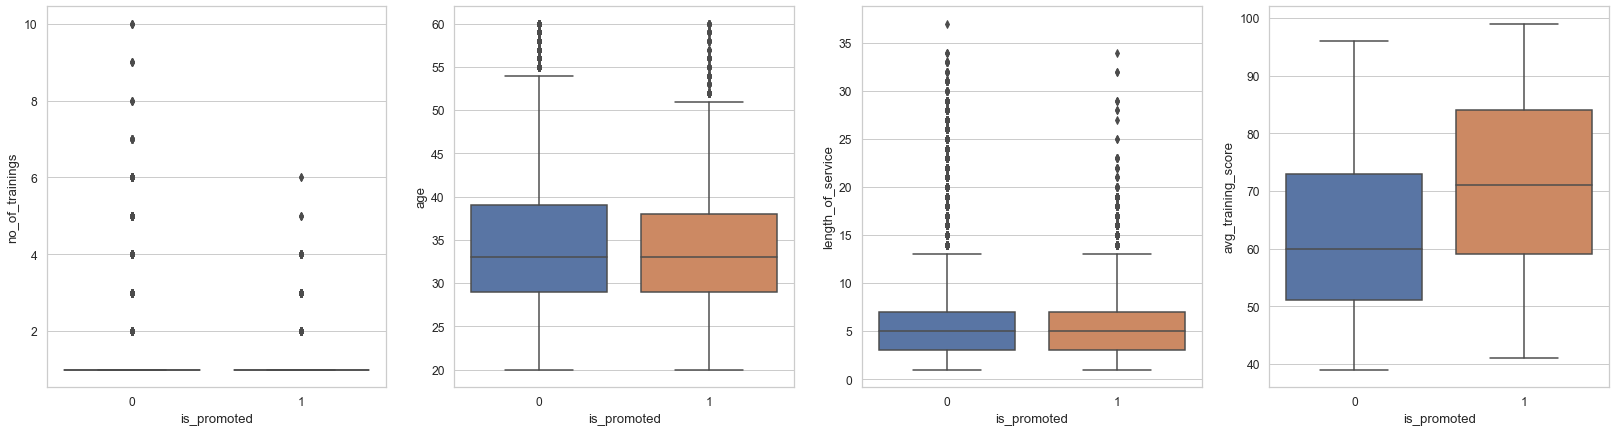

In [35]:
# Create 4 box and whisker plots for the 4 numerical variables
fig, ax = plt.subplots(1, 4, figsize=(28, 7))
for var, subplot in zip(numerical, ax.flatten()):
    sns.boxplot(x=df_explore_train['is_promoted'], y=var, data=df_explore_train, ax=subplot)

#### 1.2.2.2 Promotion rate across bins

is_promoted
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

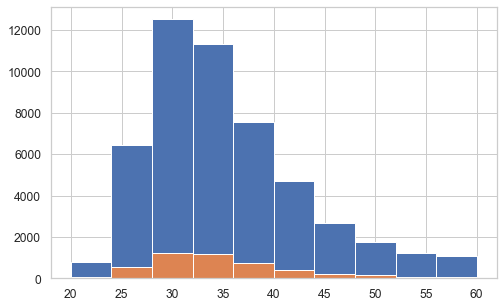

In [36]:
# View the variation for age
df_nm_bi_explore_train = df_explore_train[numerical + target] 

df_nm_bi_explore_train.groupby('is_promoted').age.hist(bins=10)

is_promoted
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length_of_service, dtype: object

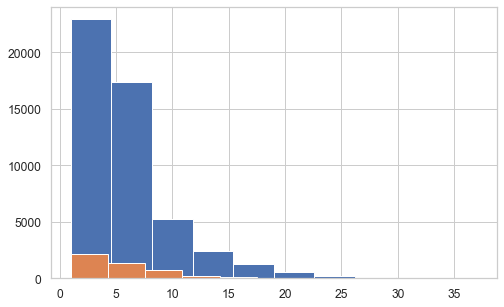

In [37]:
# View the variation for length of service
df_nm_bi_explore_train.groupby('is_promoted').length_of_service.hist(bins=10)

is_promoted
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: avg_training_score, dtype: object

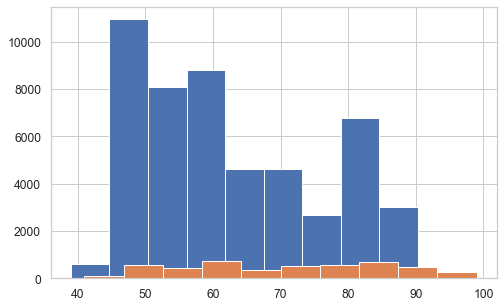

In [38]:
# View the variation for average training score
df_nm_bi_explore_train.groupby('is_promoted').avg_training_score.hist(bins=10)

is_promoted
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: no_of_trainings, dtype: object

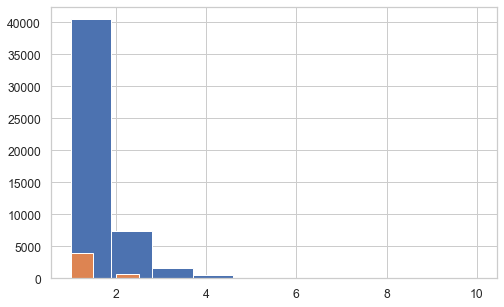

In [39]:
# View the variation for number of trainings
df_nm_bi_explore_train.groupby('is_promoted').no_of_trainings.hist(bins=10)

#### 1.2.2.3 Correlation between numerical variables

Text(0.5, 0.98, 'Numerical variables Correlation Heatmap')

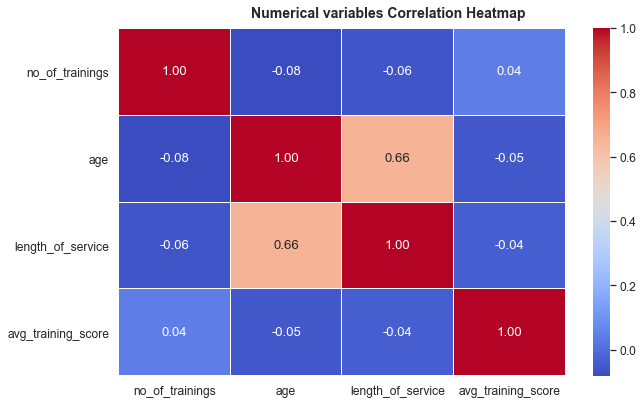

In [40]:
# Plot a correlation heatmap to see which of the numerical variables are inter-related
# Source: https://jovianlin.io/data-visualization-seaborn-part-2/

fig, (ax) = plt.subplots(1, 1, figsize=(10,6))

hm = sns.heatmap(df_explore_train[numerical].corr(), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 fmt='.2f',       # String formatting code to use when adding annotations.
                 #annot_kws={"size": 14},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
fig.suptitle('Numerical variables Correlation Heatmap', 
              fontsize=14, 
              fontweight='bold')

Very low correlations are observed between numerical variables, except length of service and age, which is naturally correlated.

### 1.2.1 Target variable vs categorical variables

#### 1.2.1.1 Event rate plots

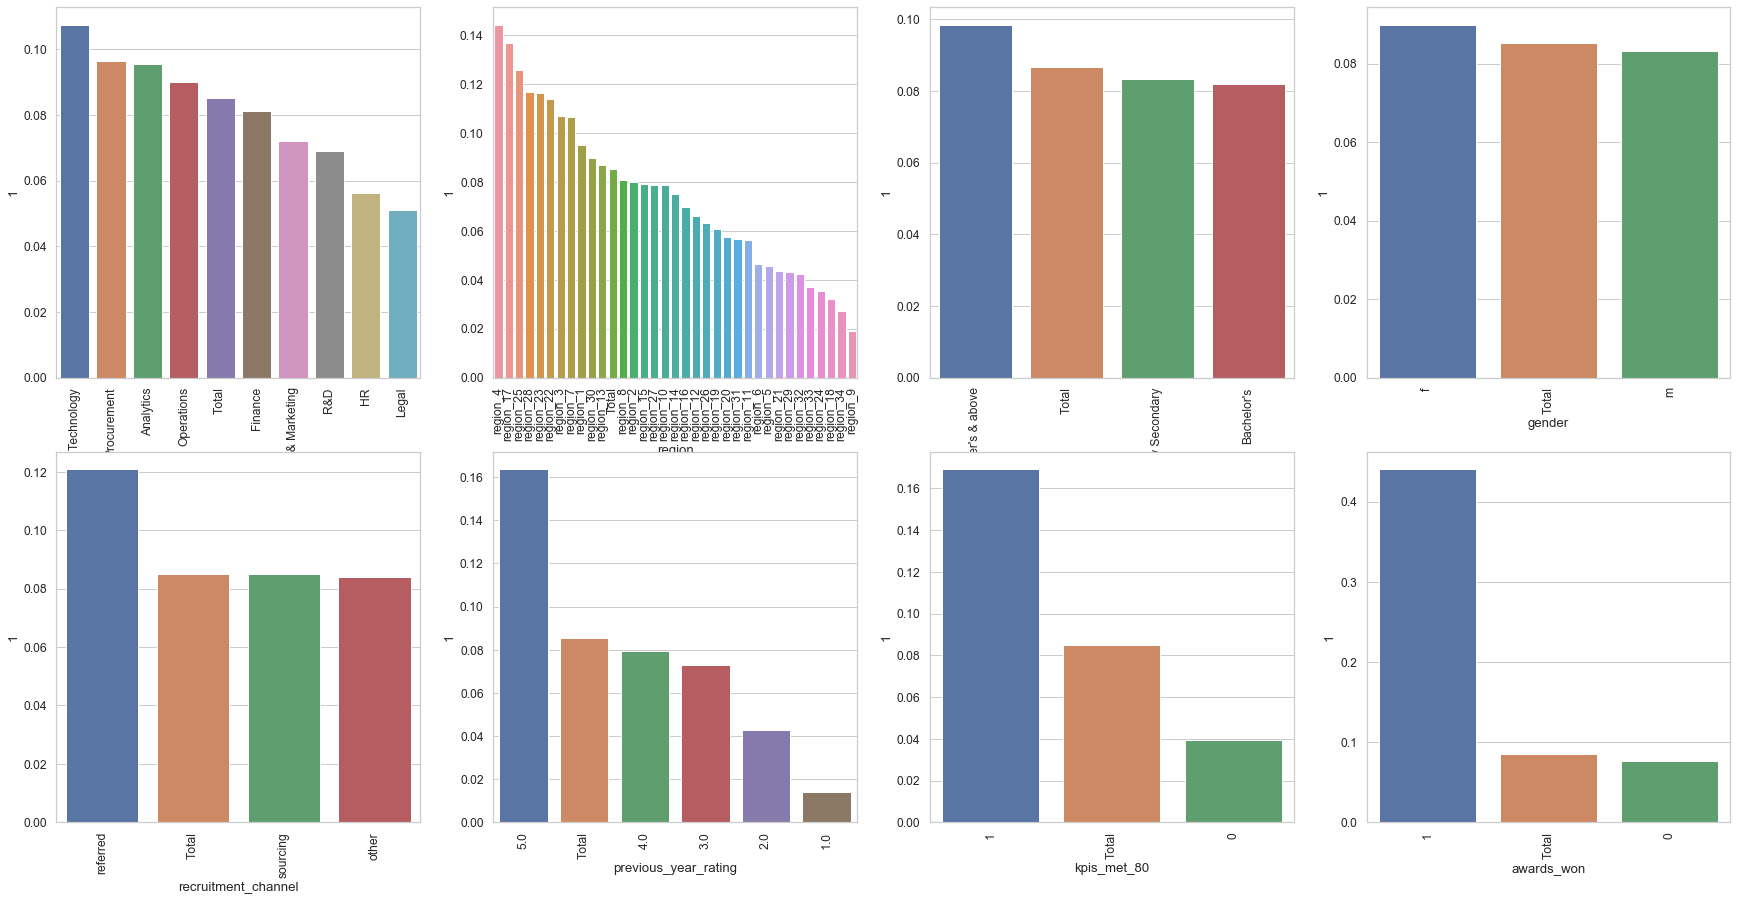

In [41]:
# Plot the event rate for each category within a categorical variable to see which categories are interesting
# For each plot, the category with the highest event rate is plotted first and then in descending order
df_cat_bi_explore_train = df_explore_train[categorical + target] 

fig, ax = plt.subplots(2, 4, figsize=(30, 15))
for var, subplot in zip(categorical, ax.flatten()):
    sns.barplot(x=var, y="1",ax=subplot,\
            data=pd.DataFrame(pd.crosstab(df_cat_bi_explore_train[var], df_cat_bi_explore_train.is_promoted,\
                                          margins=True, margins_name='Total', normalize='index')\
                              .to_records()).sort_values('1',ascending=False))
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
#,\
#            order = df_pp_explore_train[var].value_counts().sort_values(ascending=True).index

#### 1.2.1.2 Event rate tables

In [42]:
# Print the event rates for each categorical variable
for var in categorical:\
    print(pd.DataFrame(pd.crosstab(df_cat_bi_explore_train[var], df_cat_bi_explore_train.is_promoted, margins=True,\
            margins_name='Total', normalize='index').to_records()).sort_values('1',ascending=False))

          department         0         1
8         Technology  0.892407  0.107593
5        Procurement  0.903614  0.096386
0          Analytics  0.904335  0.095665
4         Operations  0.909852  0.090148
9              Total  0.914830  0.085170
1            Finance  0.918770  0.081230
7  Sales & Marketing  0.927969  0.072031
6                R&D  0.930931  0.069069
2                 HR  0.943755  0.056245
3              Legal  0.948989  0.051011
       region         0         1
28   region_4  0.855549  0.144451
8   region_17  0.863065  0.136935
17  region_25  0.874237  0.125763
20  region_28  0.883156  0.116844
15  region_23  0.883404  0.116596
14  region_22  0.885812  0.114188
22   region_3  0.893064  0.106936
31   region_7  0.893454  0.106546
0    region_1  0.904918  0.095082
23  region_30  0.910198  0.089802
4   region_13  0.913142  0.086858
34      Total  0.914830  0.085170
32   region_8  0.919084  0.080916
11   region_2  0.919874  0.080126
6   region_15  0.920940  0.079060
19  r

# Section 2 - Modeling

1) Use Random Forest (RF) and Gradient Boosting Machine (GBM) (workhorses for Data Science competitions).

2) Use 4-fold cross-validation with grid search to identify the optimal hyperparameters (4 folds were chosen to optimize on the time taken during grid search with cross validation).

3) Use ROC plot, Variable Importance report and Confusion Matrix as analytical tools to understand model performance, apart from looking at the F1 score which is the competition metric.

The modeling will be done in 3 phases:

Stage 1: Simple recoding and missing value treatment for numerical variables.

Stage 2: Examine the effect of outlier treatment on model performance.

Stage 3: Effect on model performance of feature engineering of categorical variables using one-hot encoding, count encoding and target encoding.

Important Note: Given that our test data is actually the competition test data set, we will make submissions at each stage and report the result from the competition website. This will be our test data results.

All relevant analytical output is produced in the notebook and discussed in a consolidated fashion in the report submitted.

## 2.1 Modeling Phase 1 - Simple recoding and missing value treatment

First, numerical variable age is converted into a categorical binned variable. Then, all categorical variables are converted to ordinal conversion for all categorical variables after missing value treatment.

### 2.1.1 Binning age in bands of 5

In [43]:
# Create bins using common sensical class intervals at roughly 5 year intervals and then recode for the training data
bins = [19, 25, 30, 35, 40, 45, 50, 55, 61]
group_names = ['20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60']
df_train['age_range'] = pd.cut(df_train['age'], bins, labels=group_names)

In [44]:
# Recode for the test data
df_test['age_range'] = pd.cut(df_test['age'], bins, labels=group_names)

In [45]:
# Drop the actual age variable from the data now that we have the recoded variable
df_train = df_train.drop("age", axis=1)
df_test = df_test.drop("age", axis=1)

### 2.1.2 Perform missing value treatment

Using insights from the univariate analysis, missing values in 'education' are replaced with "Bachelor's" (which is the mode); moreover, "Master's" or "Below Secondary" are comparatively uncommon values and unsuitable.

Missing values in 'previous_year_rating' are replaced with 3 which is the median rating.

In [46]:
# Perform missing value treatment in both training and test data
df_train.previous_year_rating.fillna(value = 3, inplace=True)
df_train.education.fillna(value = "Bachelor's", inplace=True)
df_test.previous_year_rating.fillna(value = 3, inplace=True)
df_test.education.fillna(value = "Bachelor's", inplace=True)

### 2.1.3 Convert categorical variables to ordinal numerical variables

The RF and GBM implementation in scikit learn don't accept categorical variables, so we have to convert them into ordinal numerical variables. We will use other methods in the next stages.

In [47]:
# Perform the categorical to ordinal numerical conversion in both the training and test data
cat_to_num = {"department": {"Analytics": 0, "Finance": 1, "HR": 2, "Legal": 3, "Operations": 4, "Procurement": 5, "R&D": 6, "Sales & Marketing": 7, "Technology": 8},
                "region": {"region_1": 1,"region_2": 2,"region_3": 3,"region_4": 4,"region_5": 5,"region_6": 6,
                          "region_7": 7,"region_8": 8,"region_9": 9,"region_10": 10,"region_11": 11,
                          "region_12": 12,"region_13": 13,"region_14": 14,"region_15": 15,"region_16": 16,"region_17": 17,
                          "region_18": 18,"region_19": 19,"region_20": 20,"region_21": 21,"region_22": 22,"region_23": 23,
                          "region_24": 24,"region_25": 25,"region_26": 26,"region_27": 27,"region_28": 28,"region_29": 29,
                          "region_30": 30,"region_31": 31,"region_32": 32,"region_33": 33,"region_34": 34},
                "age_range": {"20-25": 1, "25-30": 2, "30-35": 3, "35-40": 4, "40-45": 5, "45-50": 6, "50-55": 7, "55-60": 8},
                "education": {"Bachelor's":1, "Master's & above":2, "Below Secondary":0,},
                "recruitment_channel": {"sourcing": 0, "other": 1, "referred": 2},
                "gender": {"m": 0, "f":1}}

df_train.replace(cat_to_num, inplace=True)

df_test.replace(cat_to_num, inplace=True)

### 2.1.4 Stage 1 RF model

In [48]:
# Create the prediction set for training data
df_pred = df_train["is_promoted"]
df_pred.head()
print(df_train.head())
# Check that the sets have the correct number of rows
print(df_train.shape, df_pred.shape)
predictors = ['department', 'region', 'education', 'gender', 'recruitment_channel',\
              'no_of_trainings', 'previous_year_rating', 'length_of_service',\
              'kpis_met_80', 'awards_won', 'avg_training_score', 'age_range']

   employee_id  department  region  education  gender  recruitment_channel  \
0        65438           7       7          2       1                    0   
1        65141           4      22          1       0                    1   
2         7513           7      19          1       0                    0   
3         2542           7      23          1       0                    1   
4        48945           8      26          1       0                    1   

   no_of_trainings previous_year_rating  length_of_service kpis_met_80  \
0                1                  5.0                  8           1   
1                1                  5.0                  4           0   
2                1                  3.0                  7           0   
3                2                  1.0                 10           0   
4                1                  3.0                  2           0   

  awards_won  avg_training_score is_promoted  age_range  
0          0                

In [49]:
# parameters for grid search for Random Forest
param_grid = { 
    #'n_estimators': [1],
    'n_estimators': [100, 250],
    'max_features': [0.75],
    'max_depth': [25, 35],
    'min_samples_split': [50, 100],
    'bootstrap': [True]
}

# Define the Random Forest classifier
rfc1 = RandomForestClassifier()

# Add Grid Search with 4-fold Cross Validation to the definition
CV_rfc1 = GridSearchCV(estimator=rfc1, scoring='f1', param_grid=param_grid, cv= 4)

# Build the Random Forest model
CV_rfc1.fit(df_train[predictors], df_pred)

# Display the best hyperparameter choices
print(CV_rfc1.best_params_)

# Display the best F1 score
print(CV_rfc1.cv_results_['mean_test_score'])

# Display the F1 scores from each run to find the F1 Score corrsponding the best combination of hyperparameters
print(pd.DataFrame(CV_rfc1.cv_results_['params'], CV_rfc1.cv_results_['mean_test_score']))

# Display the Feature Importance - first column is the feature, second column is the importance
print(pd.DataFrame(CV_rfc1.best_estimator_.feature_importances_, df_train[predictors].columns,))

{'bootstrap': True, 'max_depth': 25, 'max_features': 0.75, 'min_samples_split': 50, 'n_estimators': 250}
[0.47801358 0.47861511 0.46954489 0.46927127 0.47689605 0.47821771
 0.46818545 0.47008751]
          bootstrap  max_depth  max_features  min_samples_split  n_estimators
0.478014       True         25          0.75                 50           100
0.478615       True         25          0.75                 50           250
0.469545       True         25          0.75                100           100
0.469271       True         25          0.75                100           250
0.476896       True         35          0.75                 50           100
0.478218       True         35          0.75                 50           250
0.468185       True         35          0.75                100           100
0.470088       True         35          0.75                100           250
                             0
department            0.252613
region                0.052054
education

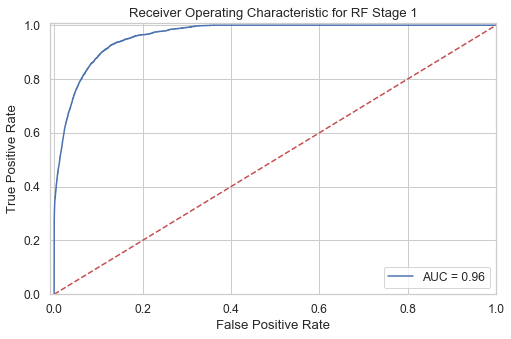

In [50]:
# ROC Plot code. Source:https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

rfc1_pred = CV_rfc1.predict_proba(df_train[predictors])

fpr, tpr, threshold = metrics.roc_curve(df_pred,  rfc1_pred[:, 1])

roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for RF Stage 1')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

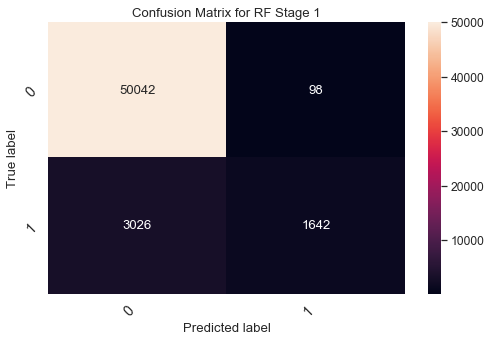

In [51]:
# Plot confusion matrix. Source: https://www.kaggle.com/arindambanerjee/grid-search-simplified
rfc1_pred_cls = CV_rfc1.predict(df_train[predictors])
plot_conf_matrix(confusion_matrix(df_pred, rfc1_pred_cls), "RF Stage 1")

### 2.1.5 Stage 1 GBM model

In [52]:
# parameters for grid search for Gradient Boosting Machine model
param_grid_gbm = { 
    'learning_rate': [0.1],
    #'n_estimators': [1],
    'n_estimators': [100, 250],
    'max_features': [0.5, 0.75],
    'subsample': [0.5, 0.75],
    'max_depth': [10],
    'min_samples_split': [100]
}

# Define the Gradient Boosting Machine classifier
gbm1 = GradientBoostingClassifier()

# Add Grid Search with Cross Validation to the definition
CV_gbm1 = GridSearchCV(estimator=gbm1, scoring='f1', param_grid=param_grid_gbm, cv= 4)

# Build the Gradient Boosting Machine model
CV_gbm1.fit(df_train[predictors], df_pred)

# Display the best hyperparameter choices
print(CV_gbm1.best_params_)

# Display the best F1 score
print(CV_gbm1.cv_results_['mean_test_score'])

# Display the F1 scores from each run to find the F1 Score corrsponding the best combination of hyperparameters
print(pd.DataFrame(CV_gbm1.cv_results_['params'], CV_gbm1.cv_results_['mean_test_score']))

# Display the Feature Importance - first column is the feature, second column is the importance
print(pd.DataFrame(CV_gbm1.best_estimator_.feature_importances_, df_train[predictors].columns,))

{'learning_rate': 0.1, 'max_depth': 10, 'max_features': 0.5, 'min_samples_split': 100, 'n_estimators': 100, 'subsample': 0.75}
[0.50212863 0.50690236 0.4973424  0.49551024 0.50259504 0.50268274
 0.4925743  0.49918296]
          learning_rate  max_depth  max_features  min_samples_split  \
0.502129            0.1         10          0.50                100   
0.506902            0.1         10          0.50                100   
0.497342            0.1         10          0.50                100   
0.495510            0.1         10          0.50                100   
0.502595            0.1         10          0.75                100   
0.502683            0.1         10          0.75                100   
0.492574            0.1         10          0.75                100   
0.499183            0.1         10          0.75                100   

          n_estimators  subsample  
0.502129           100       0.50  
0.506902           100       0.75  
0.497342           250       0.50 

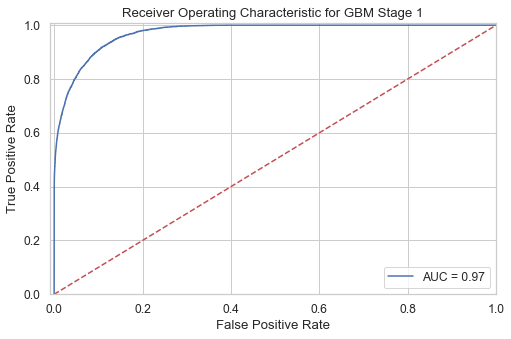

In [53]:
# ROC Plot code. Source:https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
gbm1_pred = CV_gbm1.predict_proba(df_train[predictors])

fpr, tpr, threshold = metrics.roc_curve(df_pred,  gbm1_pred[:, 1])

roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for GBM Stage 1')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

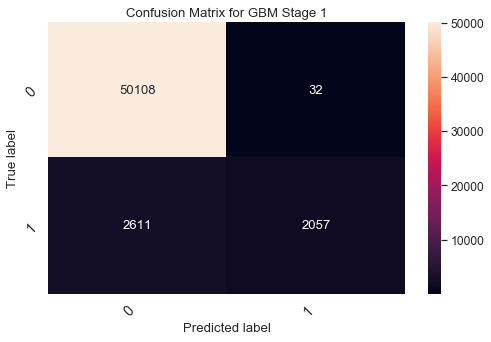

In [54]:
# Plot confusion matrix. Source: https://www.kaggle.com/arindambanerjee/grid-search-simplified
gbm1_pred_cls = CV_gbm1.predict(df_train[predictors])
plot_conf_matrix(confusion_matrix(df_pred, gbm1_pred_cls), "GBM Stage 1")

In [88]:
# Code for making submissions to site
rfc1_submit = CV_rfc1.predict(df_test[predictors])
gbm1_submit = CV_gbm1.predict(df_test[predictors])
print(rfc1_submit)
np.savetxt('C:/Users/Rudra/Desktop/HR_Problem/rfc1_submit.csv', rfc1_submit, delimiter = ",")
np.savetxt('C:/Users/Rudra/Desktop/HR_Problem/gbm1_submit.csv', gbm1_submit, delimiter = ",")

[0 0 0 ... 0 0 1]


Modeling Phase 1 Notes: Provided in detail in report.

## 2.2 Modeling Phase 2 - Outlier treatment

In this stage, the objective is to see if outlier treatment improves the performance of the best RF and GBM models from Phase 1 i.e. no hyperparameter tuning.

### 2.2.1 Outlier treatment

In [56]:
#Perform outlier treatment in both training and test data

# 99%-ile for no_of_trainings is 4
df_train['no_of_trainings'][df_train['no_of_trainings'] > 4] = 4
df_test['no_of_trainings'][df_test['no_of_trainings'] > 4] = 4

# 99%-ile for length_of_service is 21
df_train['length_of_service'][df_train['length_of_service'] > 21] = 21
df_test['length_of_service'][df_test['length_of_service'] > 21] = 21

# 99%-ile for avg_training_score is 91
df_train['avg_training_score'][df_train['avg_training_score'] > 91] = 91
df_test['avg_training_score'][df_test['avg_training_score'] > 91] = 91

### 2.2.2 Stage 2 RF model

In [77]:
# Best parameters for grid search for Random Forest from Phase 1
param_grid = { 
    #'n_estimators': [1],
    'n_estimators': [250],
    'max_features': [0.75],
    'max_depth': [25],
    'min_samples_split': [50],
    'bootstrap': [True]
}

# Define the Random Forest classifier
rfc2 = RandomForestClassifier()

# Add Grid Search with 4-fold Cross Validation to the definition
CV_rfc2 = GridSearchCV(estimator=rfc2, scoring='f1', param_grid=param_grid, cv= 4)

# Build the Random Forest model
CV_rfc2.fit(df_train[predictors], df_pred)

# Display the F1 score
print(CV_rfc2.cv_results_['mean_test_score'])

# Display the Feature Importance - first column is the feature, second column is the importance
print(pd.DataFrame(CV_rfc2.best_estimator_.feature_importances_, df_train[predictors].columns,))

[0.47847307]
                             0
department            0.254491
region                0.052349
education             0.009168
gender                0.009347
recruitment_channel   0.011671
no_of_trainings       0.012344
previous_year_rating  0.052547
length_of_service     0.040286
kpis_met_80           0.095151
awards_won            0.050357
avg_training_score    0.388277
age_range             0.024012


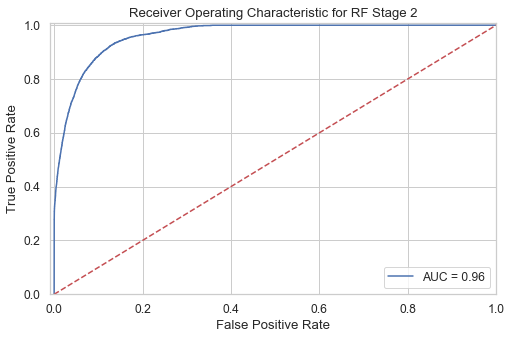

In [78]:
# ROC Plot code. Source:https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
rfc2_pred = CV_rfc2.predict_proba(df_train[predictors])

fpr, tpr, threshold = metrics.roc_curve(df_pred,  rfc2_pred[:, 1])

roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for RF Stage 2')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

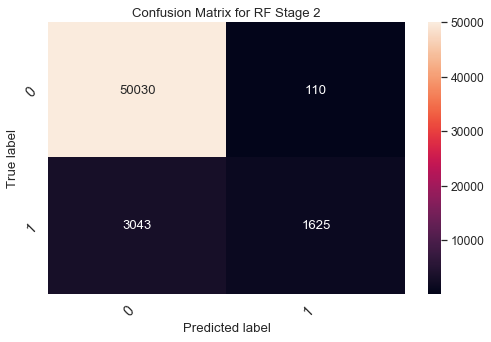

In [79]:
# Plot confusion matrix. Source: https://www.kaggle.com/arindambanerjee/grid-search-simplified
rfc2_pred_cls = CV_rfc2.predict(df_train[predictors])
plot_conf_matrix(confusion_matrix(df_pred, rfc2_pred_cls), "RF Stage 2")

### 2.2.3 Stage 2 GBM model

In [80]:
# Best parameters for grid search for GBM from Phase 1
param_grid_gbm = { 
    'learning_rate': [0.1],
    #'n_estimators': [1],
    'n_estimators': [100],
    'max_features': [0.5],
    'subsample': [0.75],
    'max_depth': [10],
    'min_samples_split': [100]
}

# Define the Gradient Boosting Machine classifier
gbm2 = GradientBoostingClassifier()

# Add Grid Search with Cross Validation to the definition
CV_gbm2 = GridSearchCV(estimator=gbm2, scoring='f1', param_grid=param_grid_gbm, cv= 4)

# Build the Gradient Boosting Machine model
CV_gbm2.fit(df_train[predictors], df_pred)

# Display the F1 score
print(CV_gbm2.cv_results_['mean_test_score'])

# Display the Feature Importance - first column is the feature, second column is the importance
print(pd.DataFrame(CV_gbm2.best_estimator_.feature_importances_, df_train[predictors].columns,))

[0.50564215]
                             0
department            0.174327
region                0.063023
education             0.011093
gender                0.012023
recruitment_channel   0.014962
no_of_trainings       0.016791
previous_year_rating  0.056912
length_of_service     0.051722
kpis_met_80           0.101148
awards_won            0.058194
avg_training_score    0.409895
age_range             0.029911


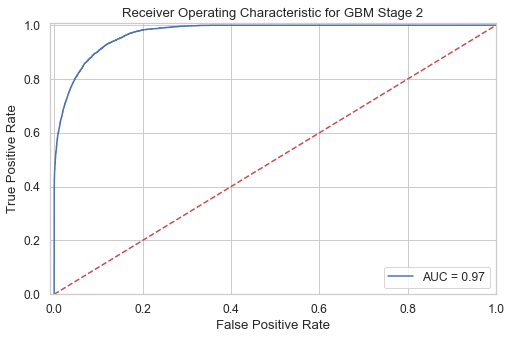

In [81]:
# ROC Plot code. Source:https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

gbm2_pred = CV_gbm2.predict_proba(df_train[predictors])

fpr, tpr, threshold = metrics.roc_curve(df_pred,  gbm2_pred[:, 1])

roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for GBM Stage 2')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

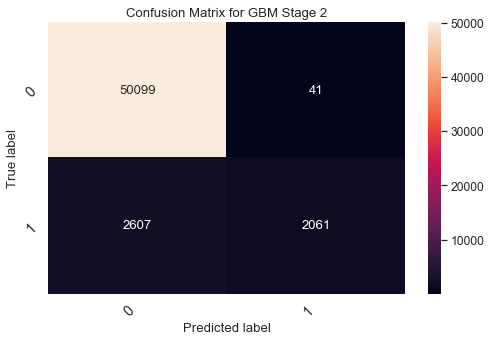

In [82]:
# Plot confusion matrix. Source: https://www.kaggle.com/arindambanerjee/grid-search-simplified
gbm2_pred_cls = CV_gbm2.predict(df_train[predictors])
plot_conf_matrix(confusion_matrix(df_pred, gbm2_pred_cls), "GBM Stage 2")

In [91]:
# Code for making submissions to site
rfc2_submit = CV_rfc2.predict(df_test[predictors])
gbm2_submit = CV_gbm2.predict(df_test[predictors])

np.savetxt('C:/Users/Rudra/Desktop/HR_Problem/rfc2_submit.csv', rfc2_submit, delimiter = ",")
np.savetxt('C:/Users/Rudra/Desktop/HR_Problem/gbm2_submit.csv', gbm2_submit, delimiter = ",")

Modeling Phase 2 Notes: Provided in detail in report.

## 2.3 Modeling Phase 3 - Feature Engineering

In this phase, three different types of categorical variable transformations are used.

1) One-hot encoding - Replace a category with 1/0 based on its presence/absence in a particular row.

2) Count encoding - Replace a category with its overall count in the data.

3) Target encoding - Replace a category with its ratio of promoted to overall, in broad terms. Owen Zhang, one of the early grandmasters on Kaggle, has a talk on the subject (https://www.slideshare.net/OwenZhang2/tips-for-data-science-competitions). The actual method used is called "Leave One Out Encoding". A widely cited paper has a good discussion on this topic: Micci-Barreca, Daniele. (2001). A Preprocessing Scheme for High-Cardinality Categorical Attributes in Classification and Prediction Problems.. SIGKDD Explorations. 3. 27-32. 10.1145/507533.507538.

### 2.3.1 Count and target encoded variables

In target encoding variables, the basic formula is to replace each category by its event rate. The paper referenced above has a detailed discussion on how to add noise and smoothening.

LeaveOneOutEncoder package to create both the count and target encoding variables in one shot. This package implements a specific type of target encoding reffered to as Leave One Out Encoding (https://contrib.scikit-learn.org/categorical-encoding/leaveoneout.html).

In [63]:
# List the variables for which we will create the count and target encoding variables
enc = LeaveOneOutEncoder(cols = ['department', 'region', 'education', 'gender', 'recruitment_channel',\
                                 'previous_year_rating', 'kpis_met_80', 'awards_won', 'age_range'],\
                         handle_unknown = 'impute',\
                         sigma = 0.02, random_state = 42)

# Perform the encoding for both training and test data but save in a separate dataframe to avoid any issues
df_train_enc = enc.fit_transform(df_train, pd.to_numeric(df_train['is_promoted']))
df_test_enc = enc.transform(df_test)

In [64]:
# Create the training data with the original columns and the new columns
df_train_cpy = df_train.reset_index(drop=True).merge(df_train_enc[["employee_id", "loo_department",\
                                                                  "cnt_department", "loo_region",\
                                                                  "cnt_region", "loo_education",\
                                                                   "cnt_education", "loo_gender",\
                                                                   "cnt_gender", "loo_recruitment_channel",\
                                                                   "cnt_recruitment_channel",\
                                                                   "loo_previous_year_rating",\
                                                                   "cnt_previous_year_rating",\
                                                                   "loo_kpis_met_80",\
                                                                   "cnt_kpis_met_80",\
                                                                   "loo_awards_won",\
                                                                   "cnt_awards_won",\
                                                                   "loo_age_range",\
                                                                   "cnt_age_range"]],
                                                     on="employee_id", how="inner")

In [65]:
# Create the test data with the original columns and the new columns
df_test_cpy = df_test.reset_index(drop=True).merge(df_test_enc[["employee_id", "loo_department",\
                                                                  "cnt_department", "loo_region",\
                                                                  "cnt_region", "loo_education",\
                                                                   "cnt_education", "loo_gender",\
                                                                   "cnt_gender", "loo_recruitment_channel",\
                                                                   "cnt_recruitment_channel",\
                                                                   "loo_previous_year_rating",\
                                                                   "cnt_previous_year_rating",\
                                                                   "loo_kpis_met_80",\
                                                                   "cnt_kpis_met_80",\
                                                                   "loo_awards_won",\
                                                                   "cnt_awards_won",\
                                                                   "loo_age_range",\
                                                                   "cnt_age_range"]],
                                                     on="employee_id", how="inner")

### 2.3.2 One hot encoded variables

Use the pandas "get_dummies" function to create one hot encoded variables and drop the original variable.

One hot encoding is not performed for gender, awards_won and kpis_met_80 as they are binary variables.

One hot encoding is also not performed for department and region as we have already performed target encoding for them.

One hot encoding will focus only on: education, recruitment_channel, previous_year_rating and age_range.

In [66]:
# Create one hot encoded variables for training data
df_train_oh = pd.get_dummies(df_train, columns=['education','recruitment_channel', 'previous_year_rating',\
                                                'age_range'])

# Create one hot encoded variables for test data
df_test_oh = pd.get_dummies(df_test, columns=['education','recruitment_channel', 'previous_year_rating',\
                                                'age_range'])

# Check the shape to make sure things look OK
print(df_train.shape, df_test.shape, df_train_oh.shape, df_test_oh.shape)

(54808, 14) (23490, 13) (54808, 29) (23490, 28)


In [67]:
# Create the training data with the original columns and the new columns
df_train_cpy = df_train_cpy.reset_index(drop=True).merge(df_train_oh[["employee_id", "education_0",\
                                                                     "education_1", "education_2",\
                                                                     "recruitment_channel_0",\
                                                                     "recruitment_channel_1",\
                                                                     "recruitment_channel_2",\
                                                                     "previous_year_rating_1.0",\
                                                                     "previous_year_rating_2.0",\
                                                                     "previous_year_rating_3.0",\
                                                                     "previous_year_rating_4.0",\
                                                                     "previous_year_rating_5.0",\
                                                                     "age_range_1",\
                                                                     "age_range_2",\
                                                                     "age_range_3",\
                                                                     "age_range_4",\
                                                                     "age_range_5",\
                                                                     "age_range_6",\
                                                                     "age_range_7",\
                                                                     "age_range_8"]],
                                                     on="employee_id", how="inner")

In [68]:
# Create the test data with the original columns and the new columns
df_test_cpy = df_test_cpy.reset_index(drop=True).merge(df_test_oh[["employee_id", "education_0",\
                                                                     "education_1", "education_2",\
                                                                     "recruitment_channel_0",\
                                                                     "recruitment_channel_1",\
                                                                     "recruitment_channel_2",\
                                                                     "previous_year_rating_1.0",\
                                                                     "previous_year_rating_2.0",\
                                                                     "previous_year_rating_3.0",\
                                                                     "previous_year_rating_4.0",\
                                                                     "previous_year_rating_5.0",\
                                                                     "age_range_1",\
                                                                     "age_range_2",\
                                                                     "age_range_3",\
                                                                     "age_range_4",\
                                                                     "age_range_5",\
                                                                     "age_range_6",\
                                                                     "age_range_7",\
                                                                     "age_range_8"]],
                                                     on="employee_id", how="inner")

In [69]:
# Create the new list of expanded predictors after the feature engineering
predictors_cpy = ['department', 'region', 'education', 'gender', 'recruitment_channel',\
                  'no_of_trainings', 'previous_year_rating', 'length_of_service',\
                  'kpis_met_80', 'awards_won', 'avg_training_score', 'age_range', "loo_department",\
                  "cnt_department", "loo_region","cnt_region", "loo_education",\
                  "cnt_education", "loo_gender","cnt_gender", "loo_recruitment_channel",\
                  "cnt_recruitment_channel","loo_previous_year_rating","cnt_previous_year_rating",\
                  "loo_kpis_met_80","cnt_kpis_met_80","loo_awards_won","cnt_awards_won",\
                  "loo_age_range","cnt_age_range", "education_0","education_1", "education_2",\
                  "recruitment_channel_0","recruitment_channel_1","recruitment_channel_2",\
                  "previous_year_rating_1.0","previous_year_rating_2.0","previous_year_rating_3.0",\
                  "previous_year_rating_4.0", "previous_year_rating_5.0", "age_range_1",\
                  "age_range_2", "age_range_3", "age_range_4", "age_range_5", "age_range_6",\
                  "age_range_7", "age_range_8"]

### 2.3.3 Stage 3 RF model

In [70]:
# Set the hyperparameter grid
param_grid = { 
    #'n_estimators': [1],
    'n_estimators': [250, 500],
    'max_features': [0.75],
    'max_depth': [35],
    'min_samples_split': [25, 50, 100],
    'bootstrap': [True]
}

# Define the Random Forest classifier
rfc3_cpy = RandomForestClassifier()

# Add Grid Search with Cross Validation to the definition
CV_rfc3_cpy = GridSearchCV(estimator=rfc3_cpy, scoring='f1', param_grid=param_grid, cv= 4)

# Build the Gradient Boosting Machine model
CV_rfc3_cpy.fit(df_train_cpy[predictors_cpy], df_pred)

# Display the best hyperparameter choices
CV_rfc3_cpy.best_params_

# Display the best F1 score
print(CV_rfc3_cpy.cv_results_['mean_test_score'])

# Display the F1 scores from each run to find the F1 Score corrsponding the best combination of hyperparameters
print(pd.DataFrame(CV_rfc3_cpy.cv_results_['params'], CV_rfc3_cpy.cv_results_['mean_test_score']))

# Display the Feature Importance - first column is the feature, second column is the importance
print(pd.DataFrame(CV_rfc3_cpy.best_estimator_.feature_importances_, df_train_cpy[predictors_cpy].columns,))

[0.47391966 0.47277177 0.46776847 0.46721005 0.45825802 0.45738867]
          bootstrap  max_depth  max_features  min_samples_split  n_estimators
0.473920       True         35          0.75                 25           250
0.472772       True         35          0.75                 25           500
0.467768       True         35          0.75                 50           250
0.467210       True         35          0.75                 50           500
0.458258       True         35          0.75                100           250
0.457389       True         35          0.75                100           500
                                 0
department                0.057325
region                    0.008838
education                 0.000604
gender                    0.000481
recruitment_channel       0.001057
no_of_trainings           0.005503
previous_year_rating      0.003720
length_of_service         0.016807
kpis_met_80               0.011975
awards_won                0.006034
a

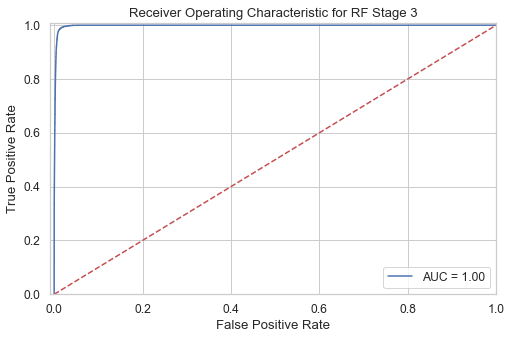

In [71]:
# ROC Plot code. Source:https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

rfc3_cpy_pred = CV_rfc3_cpy.predict_proba(df_train_cpy[predictors_cpy])

fpr, tpr, threshold = metrics.roc_curve(df_pred, rfc3_cpy_pred[:, 1])

roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for RF Stage 3')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

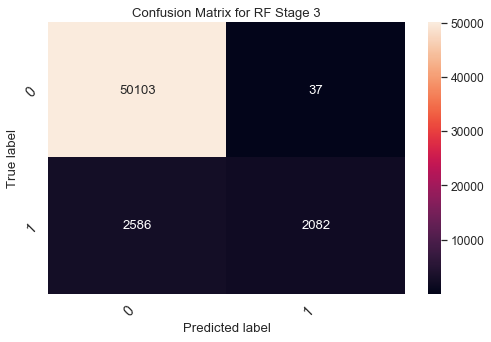

In [72]:
# Plot confusion matrix. Source: https://www.kaggle.com/arindambanerjee/grid-search-simplified
rfc3_cpy_pred_cls = CV_rfc3_cpy.predict(df_train_cpy[predictors_cpy])
plot_conf_matrix(confusion_matrix(df_pred, rfc3_cpy_pred_cls), "RF Stage 3")

### 2.3.4 Stage 3 GBM model

In [73]:
# Set the hyperparameter grid
param_grid_gbm = { 
    'learning_rate': [0.1],
    #'n_estimators': [1],
    'n_estimators': [250],
    'max_features': [0.75],
    'subsample': [0.5, 0.75],
    'max_depth': [5],
    'min_samples_split': [25, 50, 100]
}

# Define the Gradient Boosting Machine classifier
gbm3_cpy = GradientBoostingClassifier()

# Add Grid Search with Cross Validation to the definition
CV_gbm3_cpy = GridSearchCV(estimator=gbm3_cpy, scoring='f1', param_grid=param_grid_gbm, cv= 4)

# Build the Gradient Boosting Machine model
CV_gbm3_cpy.fit(df_train_cpy[predictors_cpy], df_pred)

# Display the best hyperparameter choices
CV_gbm3_cpy.best_params_

# Display the best F1 score
print(CV_gbm3_cpy.cv_results_['mean_test_score'])

# Display the F1 scores from each run to find the F1 Score corrsponding the best combination of hyperparameters
print(pd.DataFrame(CV_gbm3_cpy.cv_results_['params'], CV_gbm3_cpy.cv_results_['mean_test_score']))

# Display the Feature Importance - first column is the feature, second column is the importance
print(pd.DataFrame(CV_gbm3_cpy.best_estimator_.feature_importances_, df_train_cpy[predictors_cpy].columns,))

[0.48513063 0.49167225 0.48385621 0.49473752 0.48298092 0.49122474]
          learning_rate  max_depth  max_features  min_samples_split  \
0.485131            0.1          5          0.75                 25   
0.491672            0.1          5          0.75                 25   
0.483856            0.1          5          0.75                 50   
0.494738            0.1          5          0.75                 50   
0.482981            0.1          5          0.75                100   
0.491225            0.1          5          0.75                100   

          n_estimators  subsample  
0.485131           250       0.50  
0.491672           250       0.75  
0.483856           250       0.50  
0.494738           250       0.75  
0.482981           250       0.50  
0.491225           250       0.75  
                                 0
department                0.047077
region                    0.003914
education                 0.000123
gender                    0.000140
recruit

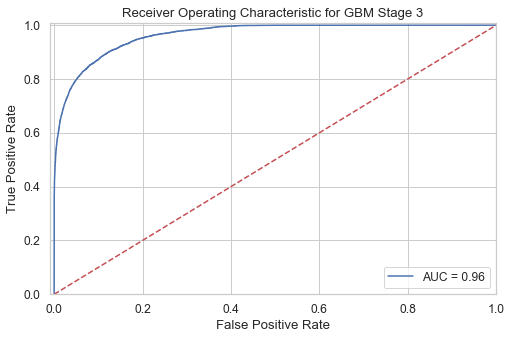

In [74]:
# ROC Plot code. Source:https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

gbm3_cpy_pred = CV_gbm3_cpy.predict_proba(df_train_cpy[predictors_cpy])

fpr, tpr, threshold = metrics.roc_curve(df_pred, gbm3_cpy_pred[:, 1])

roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for GBM Stage 3')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

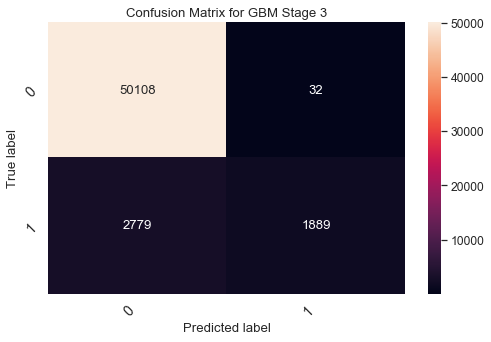

In [75]:
# Plot confusion matrix. Source: https://www.kaggle.com/arindambanerjee/grid-search-simplified
gbm3_cpy_pred_cls = CV_gbm3_cpy.predict(df_train_cpy[predictors_cpy])
plot_conf_matrix(confusion_matrix(df_pred, gbm3_cpy_pred_cls), "GBM Stage 3")

In [89]:
# Code for making submissions to site
rfc3_submit = CV_rfc3_cpy.predict(df_test_cpy[predictors_cpy])
gbm3_submit = CV_gbm3_cpy.predict(df_test_cpy[predictors_cpy])

np.savetxt('C:/Users/Rudra/Desktop/HR_Problem/rfc3_submit.csv', rfc3_submit, delimiter = ",")
np.savetxt('C:/Users/Rudra/Desktop/HR_Problem/gbm3_submit.csv', gbm3_submit, delimiter = ",")

Modeling Phase 3 Notes: Provided in detail in report.